# Preparing nested simulations  

Running a nested ROMS simulation involves setting up a parent grid (red outline) and a child grid (green outline), as illustrated in the figure below.

<img src="images/nesting.png" alt="A nested simulation" width="400"/>

Proper preparation of a nested simulation can significantly save computation time and ensure smooth integration between the parent and child simulations. The necessary steps are as follows:


**Steps Before Running the Parent Simulation**:
1. **Map Child Grid Boundaries**:  
   The boundaries of the child grid must be mapped onto the parent grid's indices and saved in a NetCDF file. This file instructs ROMS to output the parent simulation state at the child grid boundaries at a specified frequency.  

**Steps Before Running the Child Simulation**:

2. **Adjust Child Grid Topography and Mask**:  
   The topography and mask of the child grid need to be adjusted such that they align with the parent grid at the child boundaries.  
3. **Prepare Boundary Forcing**:  
   Boundary forcing for the child simulation is generated from the parent simulation's state, which was output as a result of the preparation in Step 1.
4. **Regrid Initial Conditions**:  
   Initial conditions for the child simulation are regridded from the parent simulation results.  

This notebook guides you through the these four steps.

## The `Nesting` object

Steps 1 and 2 are performed by using the `Nesting` object. 

In [1]:
from roms_tools import Grid, Nesting

First, we create a parent grid and a child grid using the `Grid` class, as usual.

In [2]:
parent_grid = Grid(
    nx=100, ny=100, size_x=2500, size_y=3000, center_lon=-30, center_lat=57, rot=-20
)

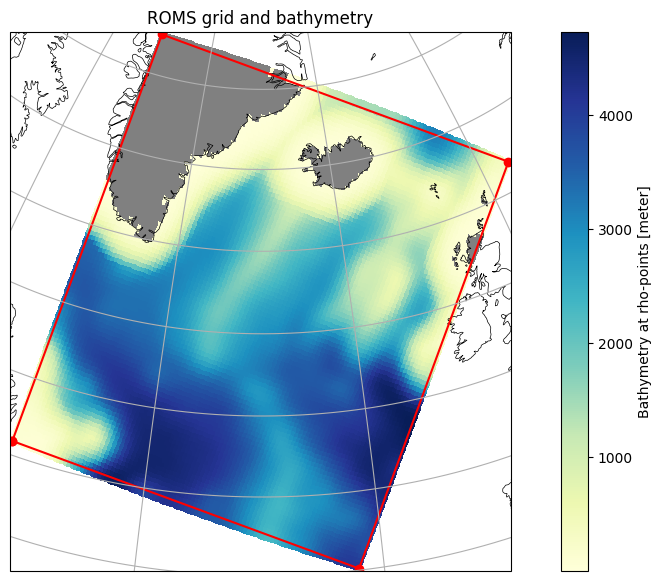

In [3]:
parent_grid.plot(bathymetry=True)

In [4]:
child_grid = Grid(
    nx=500, ny=500, size_x=400, size_y=400, center_lon=-25, center_lat=65.5, rot=10
)

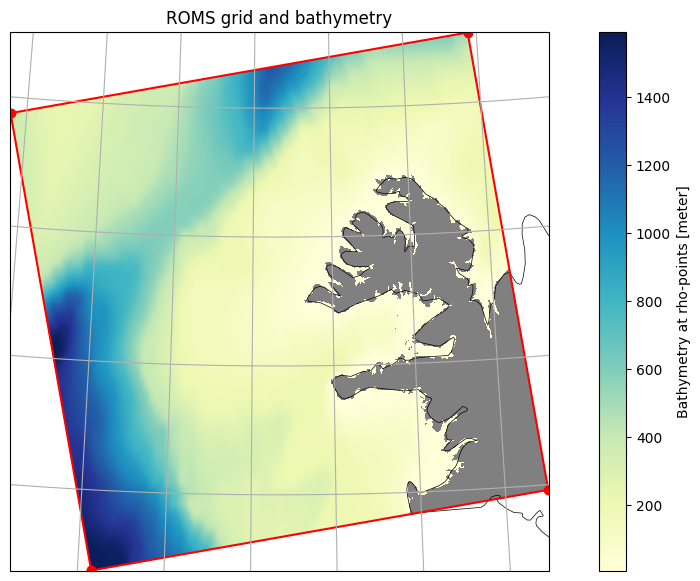

In [5]:
child_grid.plot(bathymetry=True)

For demonstration purposes, let's save the child grid's topography and mask before these variables are modified in Step 2, when creating the `Nesting` object.

In [6]:
original_child_h = child_grid.ds.h.copy()
original_child_mask = child_grid.ds.mask_rho.copy()

Next, we create the `Nesting` object, which will handle Steps 1 and 2 for us. In this example, we want the child simulation to be forced at all four boundaries and at a frequency of 1800 seconds = 30 minutes.

In [7]:
%%time

nesting = Nesting(
    parent_grid=parent_grid,
    child_grid=child_grid,
    boundaries={
        "south": True,
        "east": True,
        "north": True,
        "west": True,
    },  # which child boundaries to use in the nesting process; this is the default
    child_prefix="child",  # prefix for variable names; default is "child"
    period=1800.0,  # how frequently to output the boundary conditions for the child simulation (in seconds)
)

CPU times: user 9.53 s, sys: 7.06 ms, total: 9.54 s
Wall time: 5.84 s


Next, we can plot the parent and child grids together to visualize their relative positions.

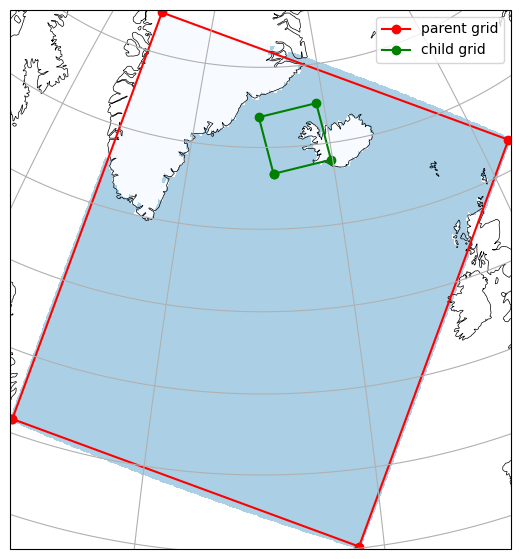

In [8]:
nesting.plot()

The boundaries of the child grid have been mapped onto the parent grid's indices (Step 1) and are now stored in an `xarray.Dataset` accessible via the `.ds` property.

In [9]:
nesting.ds

<xarray.Dataset> Size: 128kB
Dimensions:        (two: 2, child_xi_rho: 502, three: 3, child_xi_u: 501,
                    child_eta_rho: 502, child_eta_v: 501)
Coordinates:
    indices_rho    (two) <U3 24B 'xi' 'eta'
    indices_vel    (three) <U5 60B 'xi' 'eta' 'angle'
Dimensions without coordinates: two, child_xi_rho, three, child_xi_u,
                                child_eta_rho, child_eta_v
Data variables:
    child_south_r  (two, child_xi_rho) float64 8kB 43.6 43.63 ... 80.5 80.5
    child_south_u  (three, child_xi_u) float64 12kB 43.62 43.64 ... 0.09918
    child_south_v  (three, child_xi_rho) float64 12kB 43.6 43.62 ... 0.0992
    child_east_r   (two, child_eta_rho) float64 8kB 52.9 52.9 ... 91.78 91.8
    child_east_u   (three, child_eta_rho) float64 12kB 52.49 52.49 ... 0.1141
    child_east_v   (three, child_eta_v) float64 12kB 52.49 52.49 ... 0.114 0.114
    child_north_r  (two, child_xi_rho) float64 8kB 34.61 34.63 ... 91.79 91.8
    child_north_u  (three, child_xi_u) float64 12kB 34.62 34.65 ... 0.1141
    child_north_v  (three, child_xi_rho) float64 12kB 34.62 34.64 ... 0.114
    child_west_r   (two, child_eta_rho) float64 8kB 43.6 43.59 ... 84.25 84.27
    child_west_u   (three, child_eta_rho) float64 12kB 43.62 43.6 ... 0.2587
    child_west_v   (three, child_eta_v) float64 12kB 43.6 43.58 ... 0.2587

To better understand the variables in `nesting.ds`, let's create a plot.

In [10]:
import matplotlib.pyplot as plt


def plot_boundary_indices(nesting, grid_location="rho"):
    fig, axs = plt.subplots(2, 2, figsize=(10, 7))

    title = (
        f"{grid_location}-points of child boundaries mapped onto parent grid indices"
    )

    if grid_location == "rho":
        grid_location = "r"
        dim = "two"
    else:
        dim = "three"

    for direction, ax in zip(["south", "east", "north", "west"], axs.flatten()):
        nesting.ds[f"child_{direction}_{grid_location}"].isel({dim: 0}).plot(
            ax=ax, label="xi-index"
        )
        nesting.ds[f"child_{direction}_{grid_location}"].isel({dim: 1}).plot(
            ax=ax, label="eta-index"
        )
        ax.set_title(f"{direction}ern child boundary")
        ax.set_ylabel("Absolute parent grid index")
        ax.legend()

    plt.tight_layout()
    fig.suptitle(title, y=1.05)

    return fig

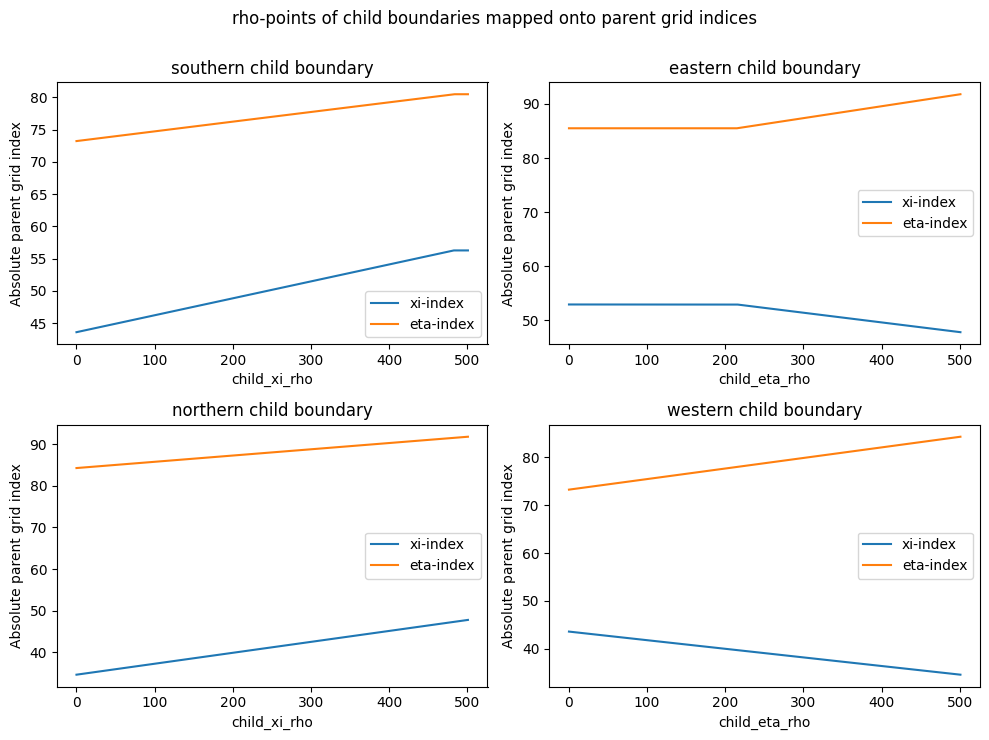

In [11]:
fig = plot_boundary_indices(nesting)

Here are a few sanity checks when comparing the spatial figure (showing the red parent grid and green child grid) with the line plots we just created:

1. The child domain is positioned in the northern part of the parent domain relative to the `eta` direction but is centrally located relative to the `xi` direction (as shown in the spatial figure). This matches the `eta-index` (orange lines), which ranges approximately from [73, 91] (out of the total `eta` range of [0, 100]), and the `xi-index`, which spans roughly [34, 56], (out of the total `xi` range of [0, 100]).

2. Along the western child boundary, moving from south to north causes the `eta` index to increase and the `xi` index to decrease (as seen in the spatial figure). This corresponds to the line plots in the fourth subplot, where the orange line increases monotonically and the blue line decreases monotonically.

3. The southern and eastern boundaries intersect with land (as indicated in the spatial figure). These are the boundaries where the line plots are not strictly monotonic. Whenever parent land is encountered, the indices are mapped to the nearest parent wet point, which explains the plateaus in the plots.

Next, we investigate the result of Step 2, which has modified the child grid topography and mask to match the parent grid. Here is a plot of the updated child topography (or equivalently, bathymetry):

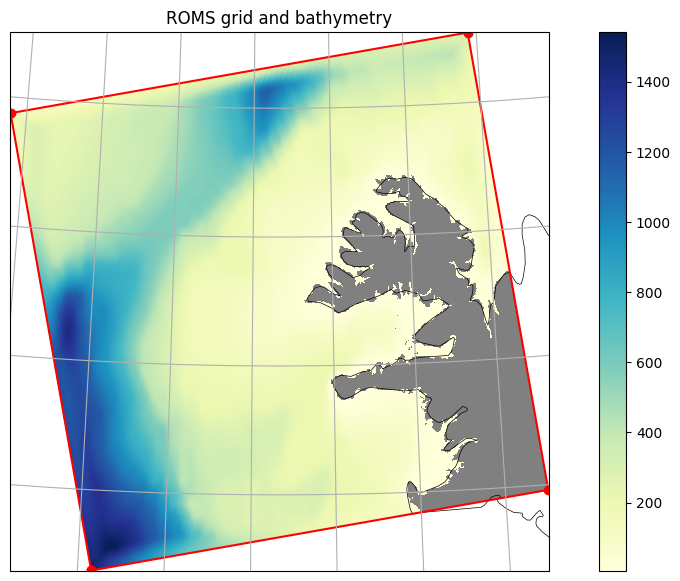

In [12]:
child_grid.plot(bathymetry=True)

At the northern boundary, the child topography is now significantly shallower than the original child topography shown earlier. We can visualize this directly by plotting their difference.

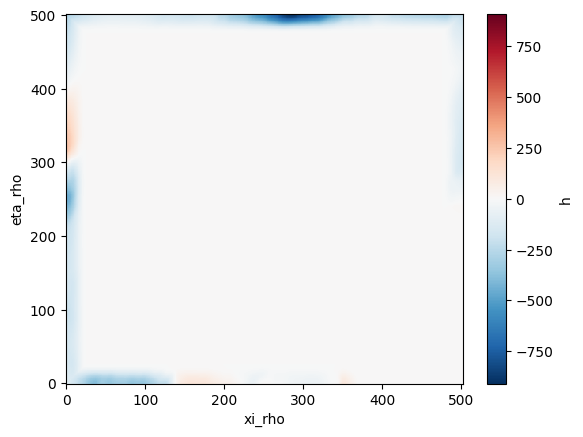

In [13]:
(child_grid.ds.h - original_child_h).plot()

The topography modifications are concentrated near the boundaries. Everywhere else, the child topography remains unchanged.

The child mask has also been adjusted along the boundary to better align with the mask of the parent grid.

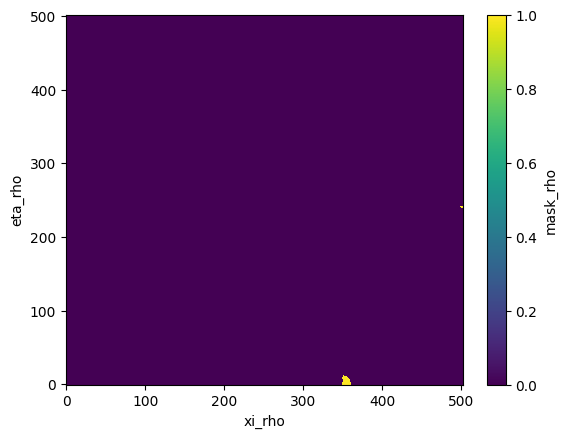

In [14]:
(child_grid.ds.mask_rho - original_child_mask).plot()

## Boundary Forcing

## Initial Conditions